In [1]:
import numpy as np
import scipy.stats
import la_forge.core as co
import pickle, json, copy, glob
import matplotlib.pyplot as plt
import corner
import matplotlib.lines as mlines
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import kalepy as kale

In [3]:
ng = co.Core(corepath="/Users/kalistaw/Desktop/OS_2023_data/ng_dmgp_core.h5")
epta = co.Core(corepath="/Users/kalistaw/Desktop/OS_2023_data/epta_dmgp_core.h5")
ppta = co.Core(corepath="/Users/kalistaw/Desktop/OS_2023_data/ppta_dmgp_core.h5")

Loading data from HDF5 file....
Loading data from HDF5 file....
Loading data from HDF5 file....


In [10]:
print(ng.get_map_param("crn_log10_A"))
print(epta.get_map_param('gw_crn_log10_A'))
print(ppta.get_map_param('gw_crn_log10_A'))

-14.383224577572454
-14.013159617210492
-16.24159062205656


In [12]:
print(ng.get_map_param("crn_gamma"))
print(epta.get_map_param('gw_crn_gamma'))
print(ppta.get_map_param('gw_crn_gamma'))

3.55843541991943
2.6520968190136274
6.7302015301857


In [11]:
ng_A_gwb = ng('crn_log10_A')
ng_A_gwb_pt = ng_A_gwb[:, np.newaxis]
epta_A_gwb = epta('gw_crn_log10_A')
epta_A_gwb_pt = epta_A_gwb[:, np.newaxis]
ppta_A_gwb = ppta('gw_crn_log10_A')
ppta_A_gwb_pt = ppta_A_gwb[:, np.newaxis]

In [5]:
ng_A_gwb

array([-14.52853444, -14.65975789, -14.5177913 , ..., -14.55432408,
       -14.55432408, -14.55432408])

In [6]:
ng_A_gwb.shape

(94800,)

In [285]:
ng_gamma_gwb = ng('crn_gamma')
ng_gamma_gwb_pt = ng_gamma_gwb[:, np.newaxis]
epta_gamma_gwb = epta('gw_crn_gamma')
epta_gamma_gwb_pt = epta_gamma_gwb[:, np.newaxis]
ppta_gamma_gwb = ppta('gw_crn_gamma')
ppta_gamma_gwb_pt = ppta_gamma_gwb[:, np.newaxis]

In [8]:
ng_gwb = np.vstack([ng_A_gwb, ng_gamma_gwb])
epta_gwb= np.vstack([epta_A_gwb, epta_gamma_gwb])
ppta_gwb= np.vstack([ppta_A_gwb, ppta_gamma_gwb])

In [286]:
ng_gwb_pt= np.hstack([ng_gamma_gwb_pt,ng_A_gwb_pt])
epta_gwb_pt= np.hstack([epta_gamma_gwb_pt,epta_A_gwb_pt])
ppta_gwb_pt= np.hstack([ppta_gamma_gwb_pt,ppta_A_gwb_pt])

In [10]:
ng_gwb.shape

(2, 94800)

In [11]:
ng_gwb_pt.shape

(94800, 2)

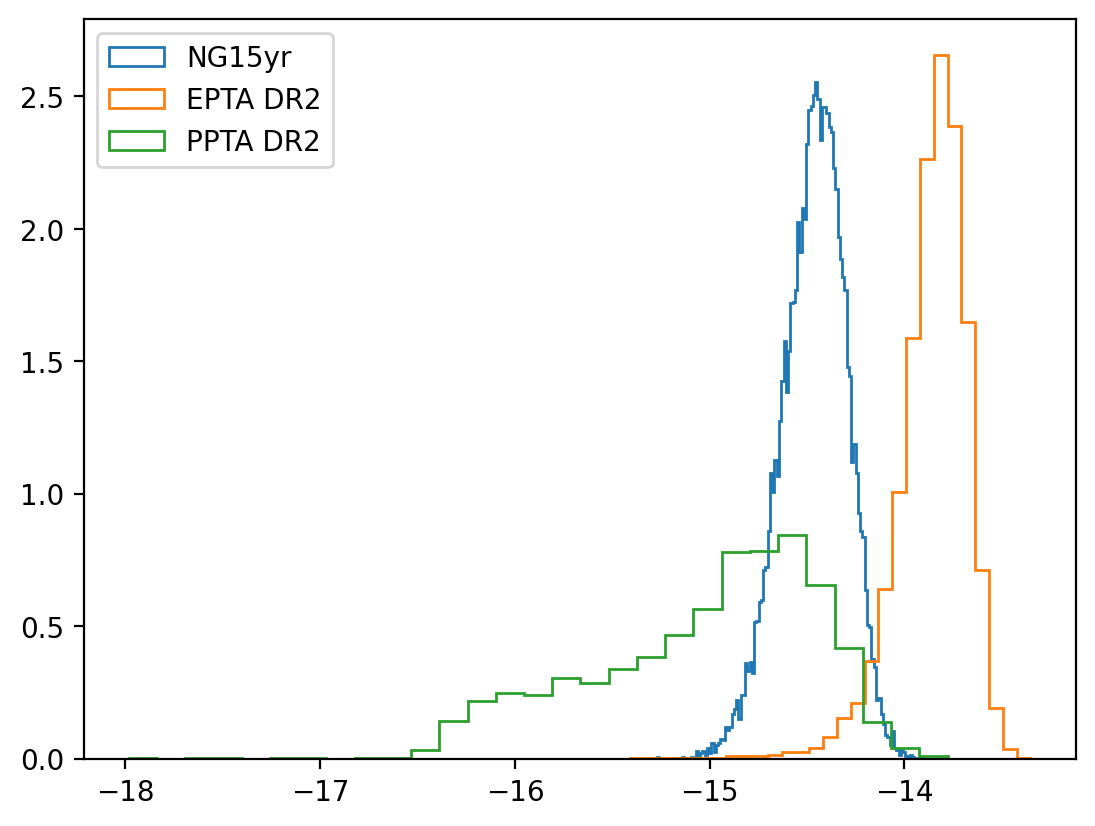

In [12]:
log=False
nbins = 30
plt.hist(ng_gwb_pt[:,0],bins=4*nbins,histtype='step',density=True,label='NG15yr',log=log)
plt.hist(epta_gwb_pt[:,0],bins=nbins,histtype='step',density=True,label='EPTA DR2',log=log)
plt.hist(ppta_gwb_pt[:,0],bins=nbins,histtype='step',density=True,label='PPTA DR2',log=log)
plt.legend(loc='upper left')
plt.show()

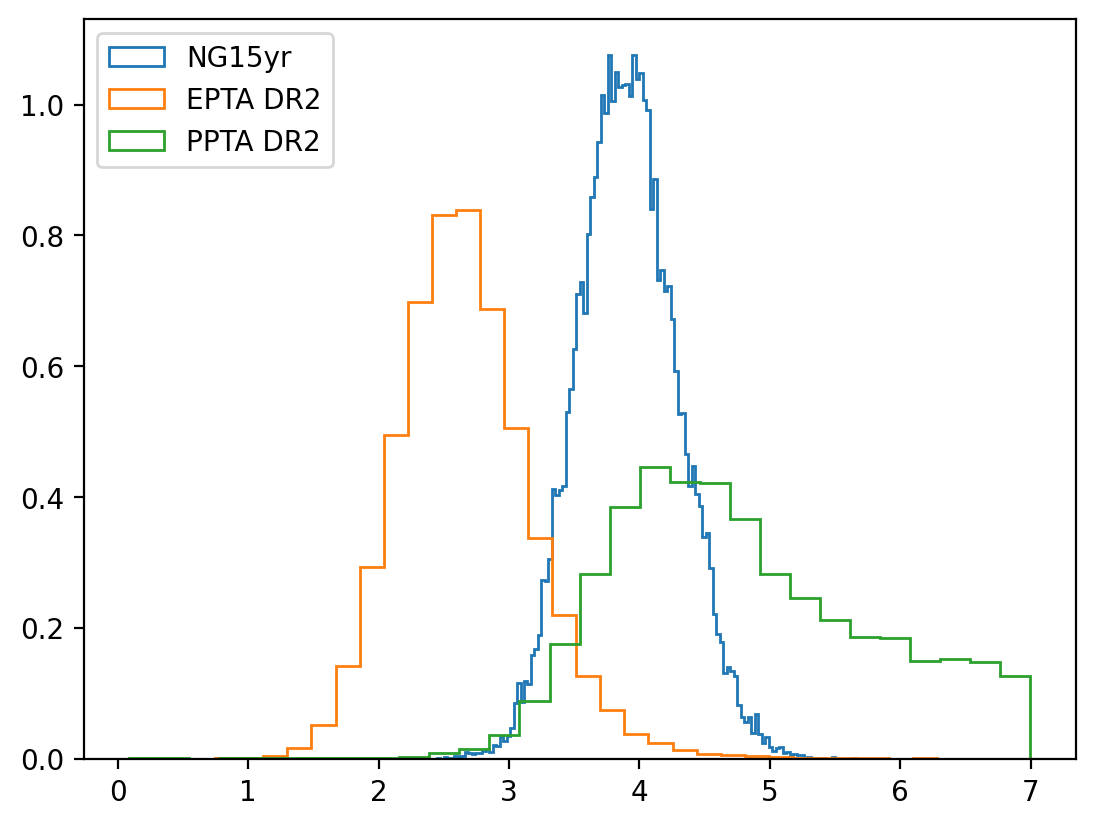

In [13]:
log=False
nbins = 30
plt.hist(ng_gwb_pt[:,1],bins=4*nbins,histtype='step',density=True,label='NG15yr',log=log)
plt.hist(epta_gwb_pt[:,1],bins=nbins,histtype='step',density=True,label='EPTA DR2',log=log)
plt.hist(ppta_gwb_pt[:,1],bins=nbins,histtype='step',density=True,label='PPTA DR2',log=log)
plt.legend(loc='upper left')
plt.show()

In [350]:
CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=5,
    labels=["crn_gamma","crn_log10_A"],
    bins=35,
)

In [351]:
def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)

def overlaid_corner(samples_list, sample_labels):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.colormaps.get_cmap('Set1')
    #colors = [cmap(i) for i in range(n)]
    
    colors=['C3','C0','C2','k']
    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)])-1,
                max([max(samples_list[i].T[dim]) for i in range(n)])+1,
            ]
        )


    CORNER_KWARGS.update(range=plot_range)

    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=15, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    
    )
    
    fig.suptitle('Varied $\gamma$ Analyses',fontsize=20)
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
    plt.savefig("/Users/kalistaw/Desktop/2d_parameter_space.pdf")
    plt.show()
    plt.close()

In [342]:
gwb_list=[epta_gwb_pt,ppta_gwb_pt,ng_gwb_pt]
gwb_labels=["EPTA","PPTA","NANOGrav"]

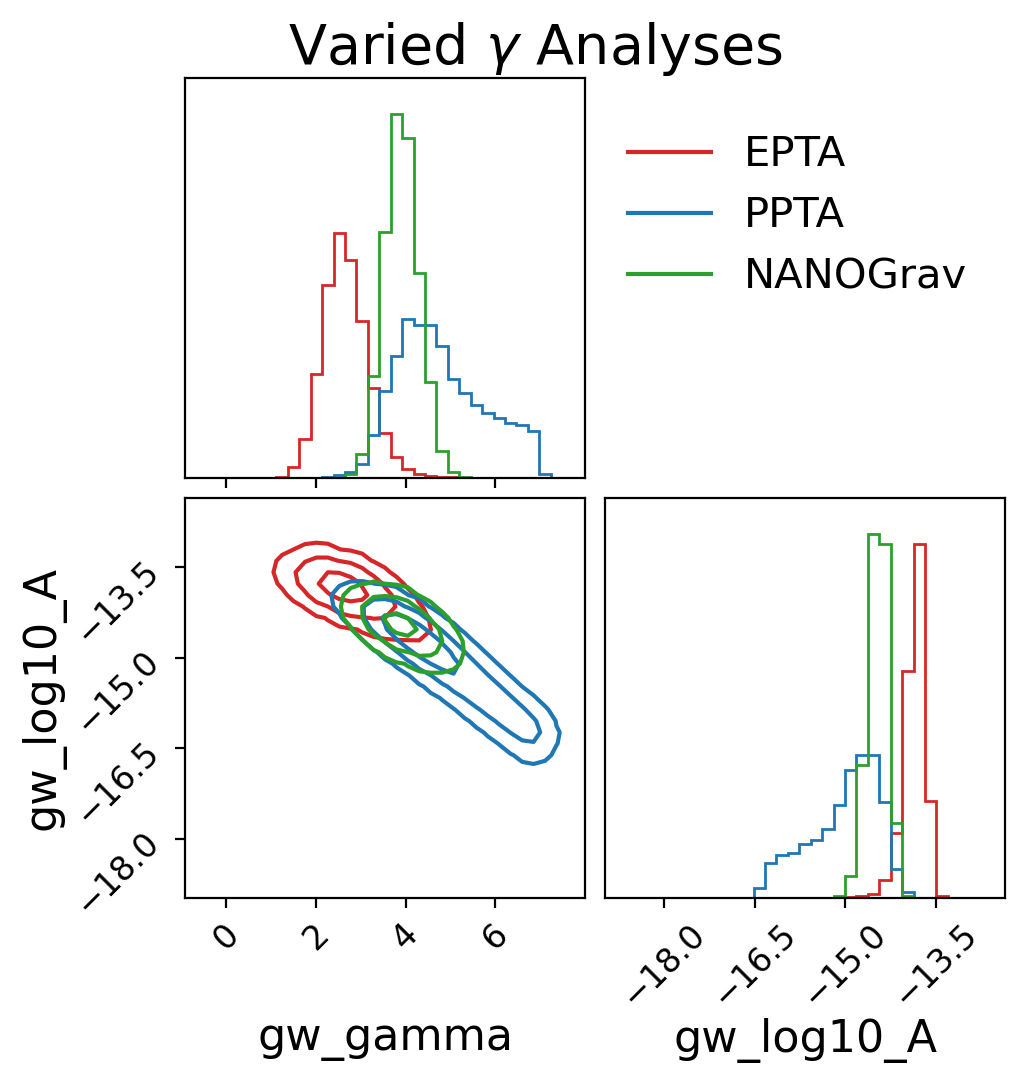

In [343]:
overlaid_corner(gwb_list,gwb_labels)

In [168]:
bin_num_A = 150
bin_num_gamma=150
linspace_A = [-18,-12]
linspace_gamma = [0,7]
bins_A = np.linspace(linspace_A[0],linspace_A[1],bin_num_A)
bins_gamma = np.linspace(linspace_gamma[0],linspace_gamma[1],bin_num_gamma)
bighist = np.zeros((3,len(bins_A),len(bins_gamma)))

bins=np.array([bins_A,bins_gamma])
linspace=np.array([linspace_A,linspace_gamma])

print(bins.shape)
print(linspace)
print(ng_gwb.shape)
print(epta_gwb.shape)
print(ppta_gwb.shape)
print(bighist.shape)

points, bighist[0,:,:] = kale.density(ng_gwb, points=bins, reflect=linspace, probability=True,grid=True)
_, bighist[1,:,:] = kale.density(epta_gwb, points=bins, reflect=linspace, probability=True,grid=True)
_, bighist[2,:,:] = kale.density(ppta_gwb, points=bins, reflect=linspace, probability=True,grid=True)


fullhist = np.prod(bighist,axis=0)
print(fullhist.shape)

(2, 150)
[[-18 -12]
 [  0   7]]
(2, 94800)
(2, 284475)
(2, 352500)
(3, 150, 150)
(150, 150)


In [169]:
bins

array([[-18.        , -17.95973154, -17.91946309, -17.87919463,
        -17.83892617, -17.79865772, -17.75838926, -17.71812081,
        -17.67785235, -17.63758389, -17.59731544, -17.55704698,
        -17.51677852, -17.47651007, -17.43624161, -17.39597315,
        -17.3557047 , -17.31543624, -17.27516779, -17.23489933,
        -17.19463087, -17.15436242, -17.11409396, -17.0738255 ,
        -17.03355705, -16.99328859, -16.95302013, -16.91275168,
        -16.87248322, -16.83221477, -16.79194631, -16.75167785,
        -16.7114094 , -16.67114094, -16.63087248, -16.59060403,
        -16.55033557, -16.51006711, -16.46979866, -16.4295302 ,
        -16.38926174, -16.34899329, -16.30872483, -16.26845638,
        -16.22818792, -16.18791946, -16.14765101, -16.10738255,
        -16.06711409, -16.02684564, -15.98657718, -15.94630872,
        -15.90604027, -15.86577181, -15.82550336, -15.7852349 ,
        -15.74496644, -15.70469799, -15.66442953, -15.62416107,
        -15.58389262, -15.54362416, -15.

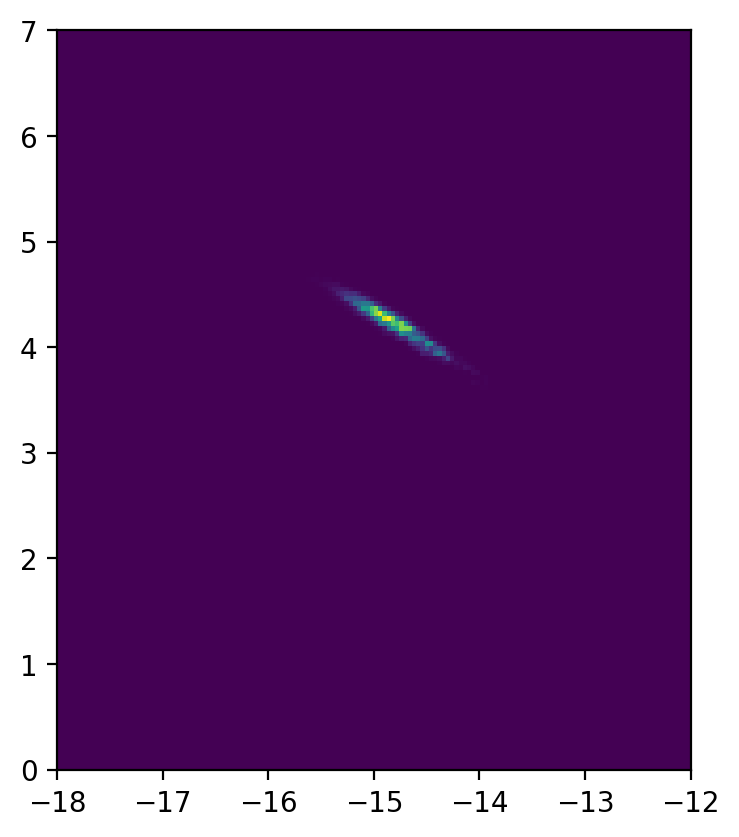

In [171]:
plt.imshow(fullhist,extent=[points[0][0],points[0][-1],points[1][0],points[1][-1]],origin='lower')
plt.show()

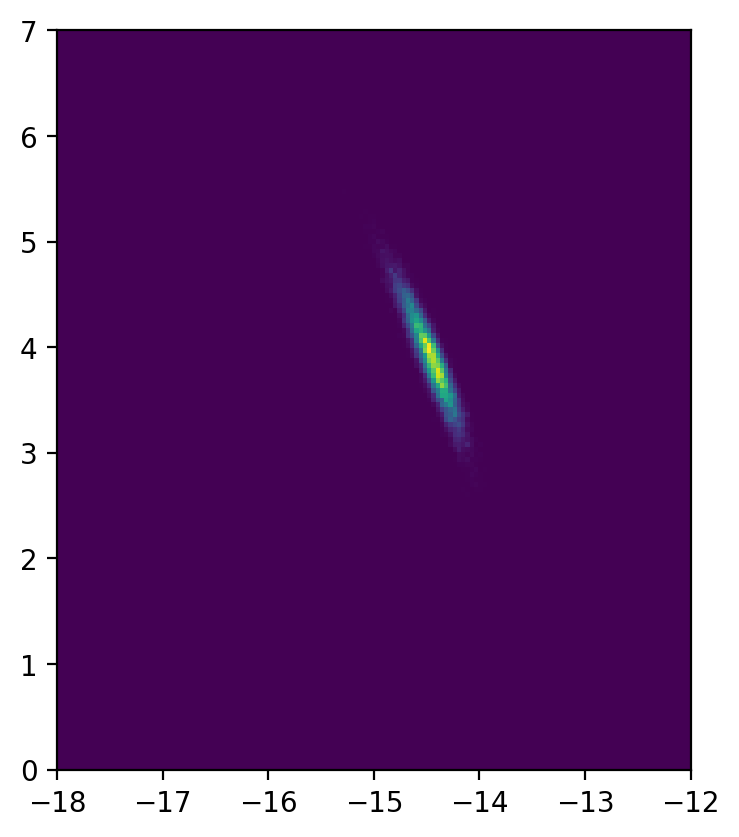

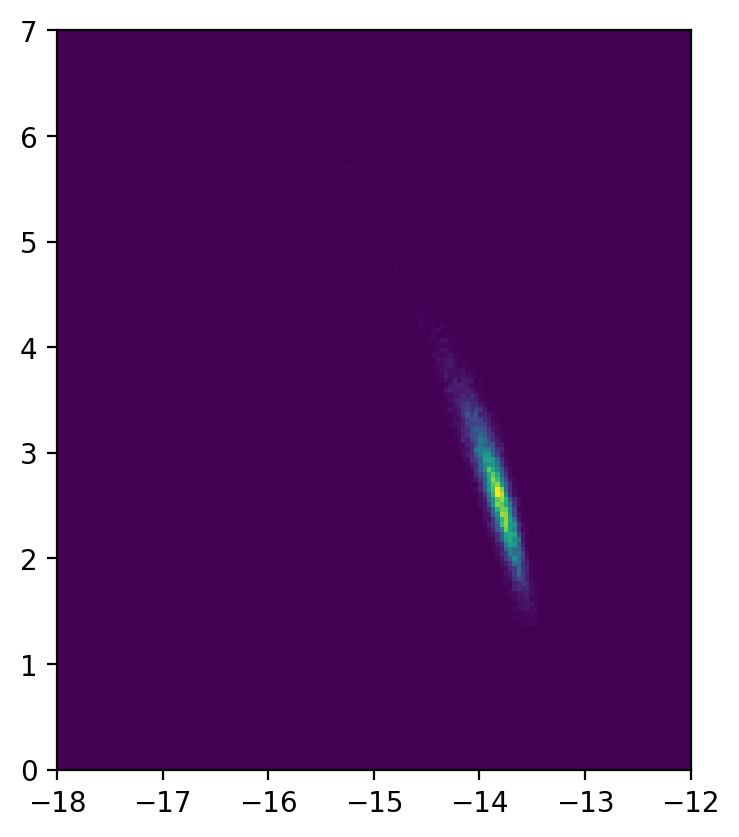

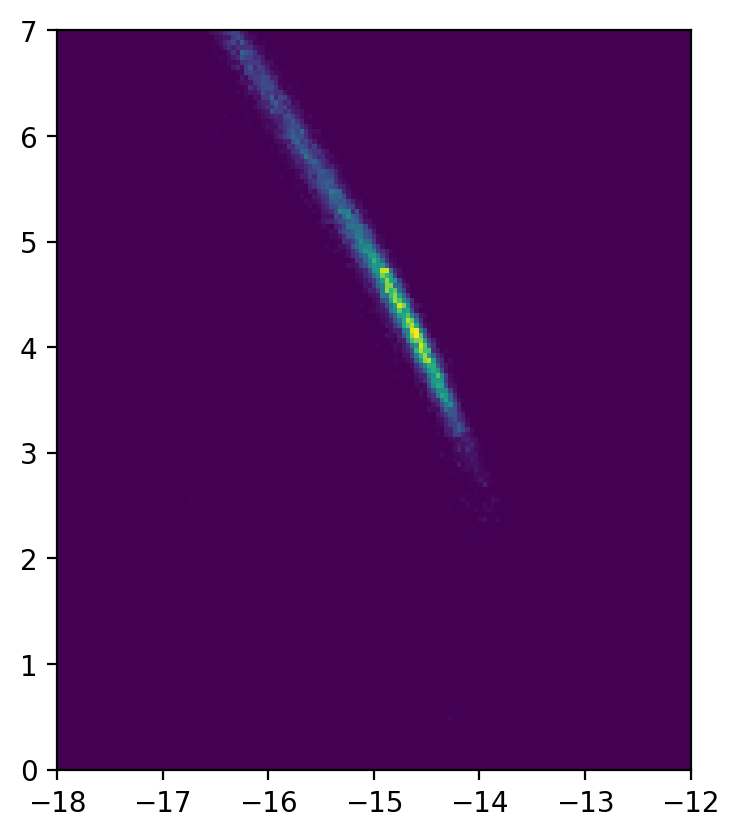

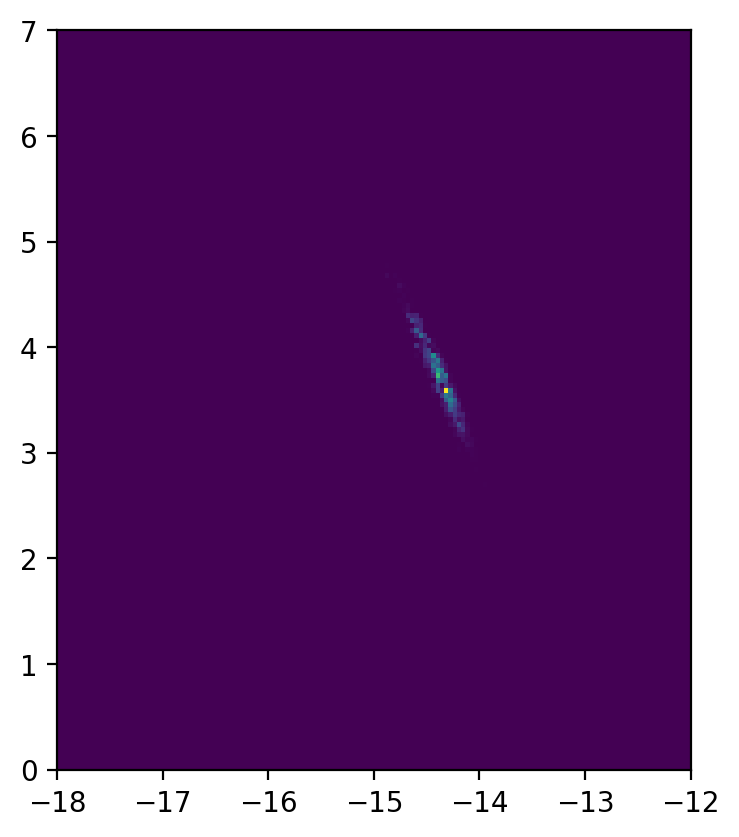

In [150]:
nghist2d,xedge,yedge=np.histogram2d(x=ng_gwb[1],y=ng_gwb[0],bins=[bins[1],bins[0]],density=True)
eptahist2d,xedge,yedge=np.histogram2d(x=epta_gwb[1],y=epta_gwb[0],bins=[bins[1],bins[0]],density=True)
pptahist2d,xedge,yedge=np.histogram2d(x=ppta_gwb[1],y=ppta_gwb[0],bins=[bins[1],bins[0]],density=True)
plt.imshow(nghist2d,extent=[yedge[0],yedge[-1],xedge[0],xedge[-1],],origin='lower')
plt.show()
plt.imshow(eptahist2d,extent=[yedge[0],yedge[-1],xedge[0],xedge[-1],],origin='lower')
plt.show()
plt.imshow(pptahist2d,extent=[yedge[0],yedge[-1],xedge[0],xedge[-1],],origin='lower')
plt.show()
plt.imshow(nghist2d*eptahist2d*pptahist2d,extent=[yedge[0],yedge[-1],xedge[0],xedge[-1],],origin='lower')
plt.show()


In [59]:
# bin_num = 150
# linspace = [-18,-14]
# bins = np.linspace(linspace[0],linspace[1],bin_num)
# bighist = np.zeros((3,len(bins)))

# print(bins)
# print(linspace)
# print(ng_gwb_pt[:,0])

# _, bighist[0,:] = kale.density(ng_gwb_pt[:,0], points=bins, reflect=linspace, probability=True)
# _, bighist[1,:] = kale.density(epta_gwb_pt[:,0], points=bins, reflect=linspace, probability=True)
# _, bighist[2,:] = kale.density(ppta_gwb_pt[:,0], points=bins, reflect=linspace, probability=True)

# fullhist = np.prod(bighist,axis=0)
# fullhist = (fullhist[1:]+fullhist[:-1])/2 #--probability at center 

In [60]:
# plt.hist(fullhist, bins=35)

In [172]:
grid=kale.Sample_Grid(bins,fullhist)

In [217]:
samples=grid.sample(nsamp=10000)

In [299]:
samples

array([[-14.95166157, -14.69802319, -13.99307905, ..., -14.29592915,
        -14.29679731, -14.29671502],
       [  4.78527641,   4.69963329,   3.15554574, ...,   3.61618528,
          3.61717227,   3.61664361]])

In [300]:
gwb_A=samples[0]
gwb_gamma=samples[1]

In [301]:
gwb_A_pt = gwb_A[:, np.newaxis]
gwb_gamma_pt = gwb_gamma[:,np.newaxis]

In [302]:
overlap_gwb = np.hstack([gwb_A_pt,gwb_gamma_pt])
overlap_gwb_pt = np.hstack([gwb_gamma_pt,gwb_A_pt])

In [222]:
overlap_gwb.shape

(10000, 2)

In [68]:
# log=False
# nbins = 30
# plt.hist(ng_gwb_pt[:,0],bins=4*nbins,histtype='step',density=True,label='NanoGrav',log=log,color='C2')
# plt.hist(epta_gwb_pt[:,0],bins=nbins,histtype='step',density=True,label='EPTA',log=log,color='C3')
# plt.hist(ppta_gwb_pt[:,0],bins=nbins,histtype='step',density=True,label='PPTA',log=log,color='C0')
# plt.hist(bins,gwb_gamma.pdf(x=bins),color='purple',label='Combined')
# plt.legend(loc='upper left')
# plt.show()

In [69]:
# log=False
# nbins = 30
# plt.hist(ng_gwb[:,1],bins=4*nbins,histtype='step',density=True,label='NanoGrav',log=log,color='C2')
# plt.hist(epta_gwb[:,1],bins=nbins,histtype='step',density=True,label='EPTA',log=log,color='C3')
# plt.hist(ppta_gwb[:,1],bins=nbins,histtype='step',density=True,label='PPTA',log=log,color='C0')
# plt.plot(bins,gwb_gamma.pdf(x=bins),color='purple',label='Combined')
# plt.legend(loc='upper left')
# plt.show()

In [344]:
gwb_list=[epta_gwb_pt,ppta_gwb_pt,ng_gwb_pt,overlap_gwb_pt]
gwb_labels=["EPTA","PPTA","NANOGrav","Overlap"]

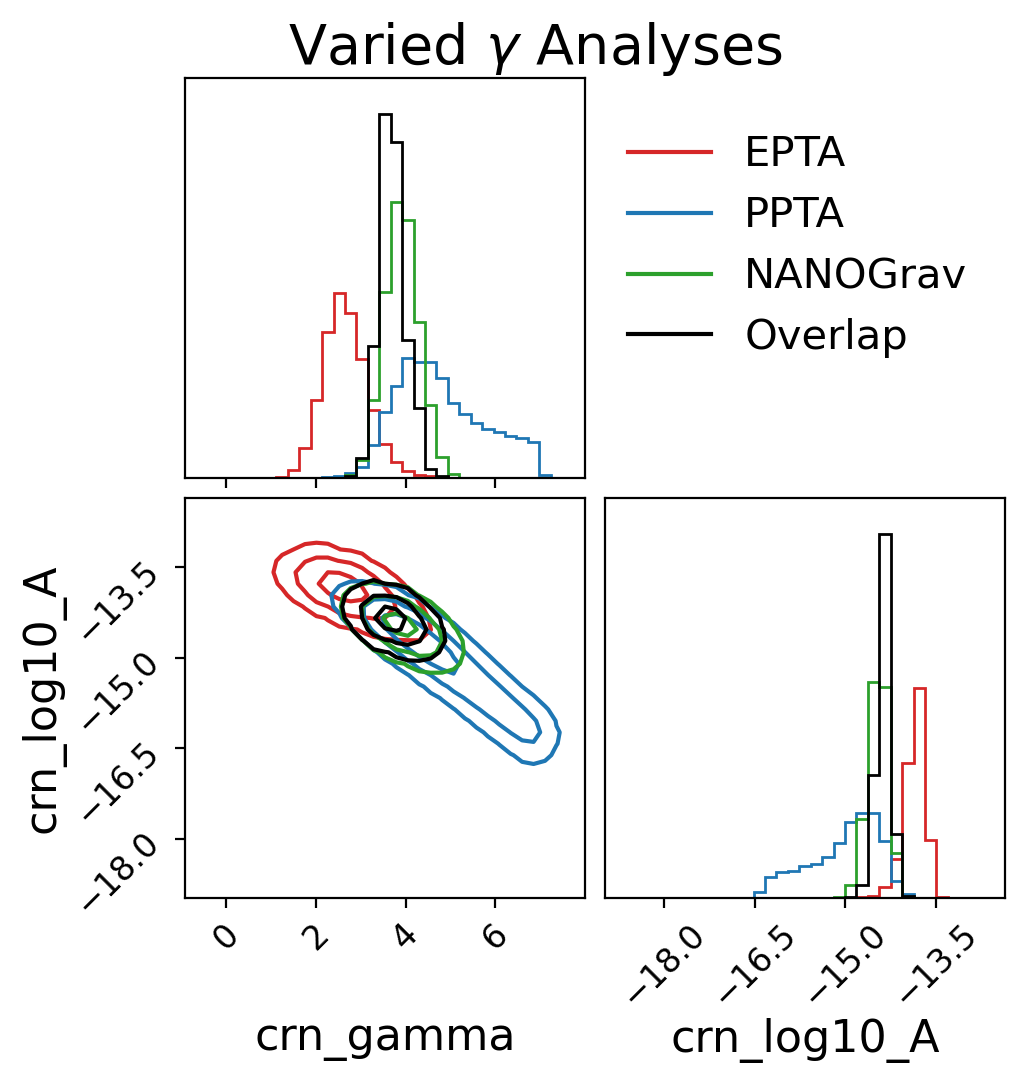

In [352]:
overlaid_corner(gwb_list,gwb_labels)

In [ ]:
#-15 and 3

In [225]:
ng_idxs = []
epta_idxs = []
ppta_idxs = []
for sa,sg in zip(gwb_A,gwb_gamma):
    ng_idxs.append(np.argmin((((ng.get_param('crn_log10_A',to_burn=False)-sa)/(-15))**2)+((ng.get_param('crn_gamma',to_burn=False)-sg)/3)**2))
    epta_idxs.append(np.argmin((((epta.get_param('gw_crn_log10_A',to_burn=False)-sa)/(-15))**2)+((epta.get_param('gw_crn_gamma',to_burn=False)-sg)/3)**2))
    ppta_idxs.append(np.argmin((((ppta.get_param('gw_crn_log10_A',to_burn=False)-sa)/(-15))**2)+((ppta.get_param('gw_crn_gamma',to_burn=False)-sg)/3)**2))

In [197]:
# ng_idxs = []
# epta_idxs = []
# ppta_idxs = []
# for sa,sg in zip(gwb_A,gwb_gamma):
#     ng_idxs.append(np.unravel_index(np.argmin((((ng.get_param('crn_log10_A',to_burn=False)-sa)/(-15))**2)+((ng.get_param('crn_gamma',to_burn=False)-sg)/3)**2),ng_gwb.shape))
#     epta_idxs.append(np.unravel_index(np.argmin((((epta.get_param('gw_crn_log10_A',to_burn=False)-sa)/(-15))**2)+((epta.get_param('gw_crn_gamma',to_burn=False)-sg)/3)**2),epta_gwb.shape))
#     ppta_idxs.append(np.unravel_index(np.argmin((((ppta.get_param('gw_crn_log10_A',to_burn=False)-sa)/(-15))**2)+((ppta.get_param('gw_crn_gamma',to_burn=False)-sg)/3)**2),ppta_gwb.shape))

In [226]:
len(ng_idxs)

10000

In [227]:
np.unique(ng_idxs).size,np.unique(epta_idxs).size,np.unique(ppta_idxs).size

(853, 423, 679)

In [244]:
ng_unq_indxs=np.unique(ng_idxs,return_index=True)
epta_unq_indxs=np.unique(epta_idxs,return_index=True)
ppta_unq_indxs=np.unique(ppta_idxs,return_index=True)

In [247]:
epta_unq_indx_idx=epta_unq_indxs[1]

In [255]:
epta_idxs=np.array(epta_idxs)

In [259]:
epta_unq_idxs=epta_idxs[epta_unq_indx_idx]
print(epta_unq_idxs.shape)
print(np.unique(epta_unq_idxs).size)

(423,)
423


In [260]:
ng_idxs=np.array(ng_idxs)
ng_unq_idxs=ng_idxs[epta_unq_indx_idx]
ppta_idxs=np.array(ppta_idxs)
ppta_unq_idxs=ppta_idxs[epta_unq_indx_idx]
print(ng_unq_idxs.shape)
print(np.unique(ng_unq_idxs).size)
print(ppta_unq_idxs.shape)
print(np.unique(ppta_unq_idxs).size)

(423,)
361
(423,)
344


In [261]:
ng.chain.shape

(126400, 287)

In [262]:
ng_chain = ng.chain[ng_unq_idxs,:]
epta_chain = epta.chain[epta_unq_idxs,:]
ppta_chain = ppta.chain[ppta_unq_idxs,:]
ng_chain.shape,epta_chain.shape,ppta_chain.shape

((423, 287), (423, 114), (423, 122))

In [263]:
np.save('/Users/kalistaw/Desktop/OS_2023_data/combined_ng_chain_vg_unq_idx.npy',ng_chain)
np.save('/Users/kalistaw//Desktop/OS_2023_data/combined_epta_chain_vg_unq_idx.npy',epta_chain)
np.save('/Users/kalistaw//Desktop/OS_2023_data/combined_ppta_chain_vg_unq_idx.npy',ppta_chain)

In [264]:
ng_parameter_names=ng.params

In [265]:
ng_parameter_names

['B1855+09_dm_gp_gamma',
 'B1855+09_dm_gp_log10_A',
 'B1855+09_red_noise_gamma',
 'B1855+09_red_noise_log10_A',
 'B1937+21_dm_gp_gamma',
 'B1937+21_dm_gp_log10_A',
 'B1937+21_red_noise_gamma',
 'B1937+21_red_noise_log10_A',
 'B1953+29_dm_gp_gamma',
 'B1953+29_dm_gp_log10_A',
 'B1953+29_red_noise_gamma',
 'B1953+29_red_noise_log10_A',
 'J0023+0923_dm_gp_gamma',
 'J0023+0923_dm_gp_log10_A',
 'J0023+0923_red_noise_gamma',
 'J0023+0923_red_noise_log10_A',
 'J0030+0451_dm_gp_gamma',
 'J0030+0451_dm_gp_log10_A',
 'J0030+0451_red_noise_gamma',
 'J0030+0451_red_noise_log10_A',
 'J0340+4130_dm_gp_gamma',
 'J0340+4130_dm_gp_log10_A',
 'J0340+4130_red_noise_gamma',
 'J0340+4130_red_noise_log10_A',
 'J0406+3039_dm_gp_gamma',
 'J0406+3039_dm_gp_log10_A',
 'J0406+3039_red_noise_gamma',
 'J0406+3039_red_noise_log10_A',
 'J0437-4715_dm_gp_gamma',
 'J0437-4715_dm_gp_log10_A',
 'J0437-4715_red_noise_gamma',
 'J0437-4715_red_noise_log10_A',
 'J0509+0856_dm_gp_gamma',
 'J0509+0856_dm_gp_log10_A',
 'J0509+

In [266]:
import pickle

with open('/Users/kalistaw/Desktop/OS_2023_data/combined_ng_params_vg_unq_idx.npy', 'wb') as fp:
    pickle.dump(ng_parameter_names, fp)

In [267]:
epta_parameter_names=epta.params

In [268]:
ppta_parameter_names=ppta.params

In [269]:
with open('/Users/kalistaw/Desktop/OS_2023_data/combined_epta_params_vg_unq_idx.npy', 'wb') as fp:
    pickle.dump(epta_parameter_names, fp)

In [270]:
with open('/Users/kalistaw/Desktop/OS_2023_data/combined_ppta_param_vg_unq_idx.npy', 'wb') as fp:
    pickle.dump(ppta_parameter_names, fp)

In [ ]:
#Do it guassian

(array([136.,   2.,   2.,   1.,   1.,   2.,   0.,   2.,   0.,   3.]),
 array([0.        , 0.1774106 , 0.3548212 , 0.5322318 , 0.7096424 ,
        0.887053  , 1.06446359, 1.24187419, 1.41928479, 1.59669539,
        1.77410599]),
 <BarContainer object of 10 artists>)

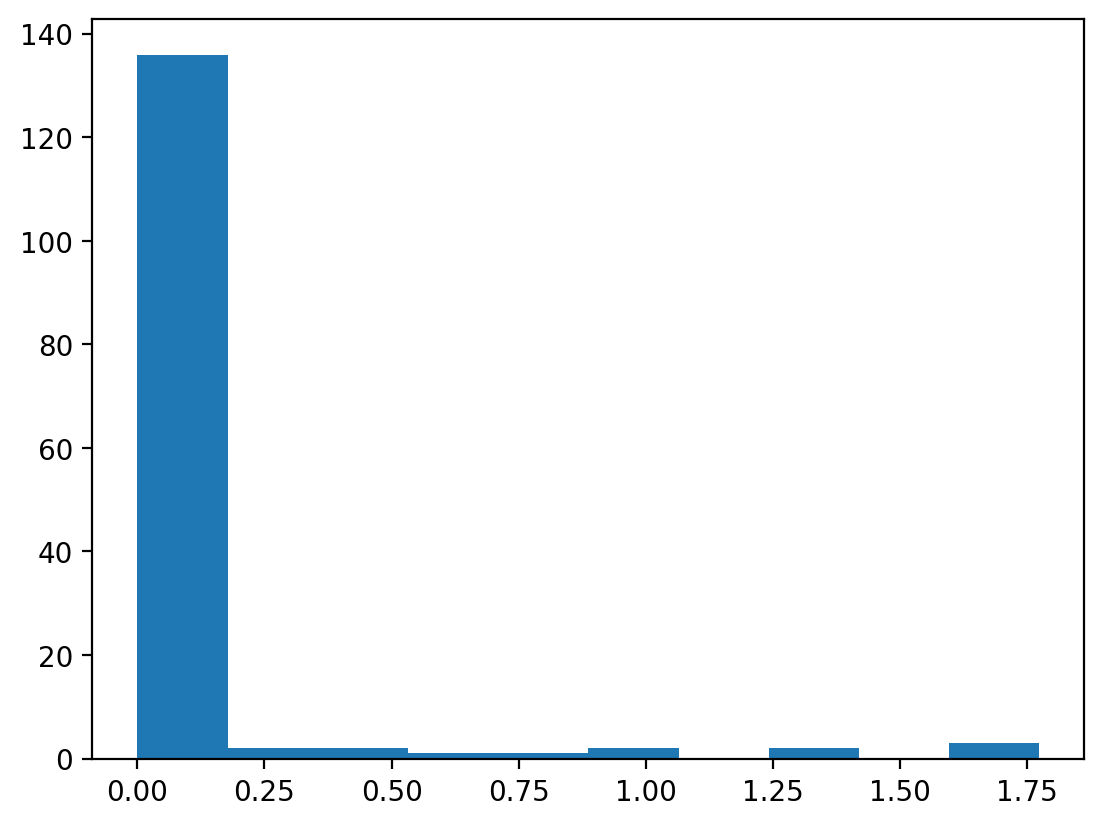

In [21]:
plt.hist(fullhist)

In [ ]:
# bin_num = 150
# linspace = [0,8]
# bins = np.linspace(linspace[0],linspace[1],bin_num)
# bighist = np.zeros((3,len(bins)))

# _, bighist[0,:] = kale.density(ng_gwb[:,1], points=bins, reflect=linspace, probability=True)
# _, bighist[1,:] = kale.density(epta_gwb[:,1], points=bins, reflect=linspace, probability=True)
# _, bighist[2,:] = kale.density(ppta_gwb[:,1], points=bins, reflect=linspace, probability=True)

# fullhist = np.prod(bighist,axis=0)
# fullhist = (fullhist[1:]+fullhist[:-1])/2

In [ ]:
# gwb_A = scipy.stats.rv_histogram([fullhist,bins])

# gwb_gamma = scipy.stats.rv_histogram([fullhist,bins])

In [ ]:
# samples_A=gwb_A.rvs(size=1000)
# samples_A = samples_A[:, np.newaxis]

# samples_gamma=gwb_gamma.rvs(size=1000)
# samples_gamma = samples_gamma[:, np.newaxis]

In [ ]:
# overlap_gwb=np.hstack([samples_A, samples_gamma])

# overlap_gwb.shape